In [1]:
import os
import sys
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Add the directory where dynamics.py and utils.py are located to sys.path
module_path = os.path.abspath(os.path.join('../src'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from dynamics import SatelliteDynamics
from utils import get_form_initial_conditions

generate_random_graph = False
maximize_independent_C_nodes = False

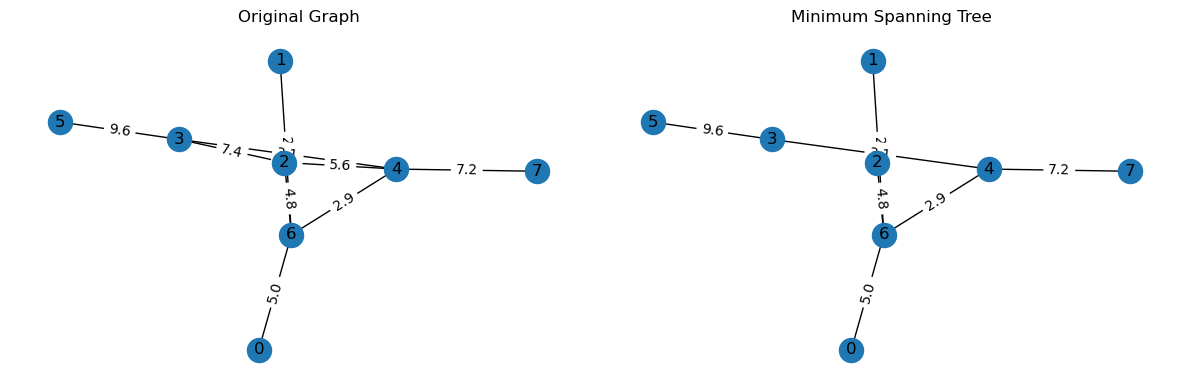

In [2]:
number_of_nodes = 8
number_of_edges = 9

if generate_random_graph:
    # Generate a random graph
    G = nx.gnm_random_graph(number_of_nodes, number_of_edges)
    
    # Ensure the graph is connected
    while not nx.is_connected(G):
        # Find connected components
        components = list(nx.connected_components(G))
        for i in range(1, len(components)):
            node_from_prev = list(components[i - 1])[0]
            node_from_curr = list(components[i])[0]
            G.add_edge(node_from_prev, node_from_curr)
            
    # Add random weights to the edges
    for (u, v) in G.edges():
        # Only with one decimal place
        G[u][v]['weight'] = round(np.random.uniform(0.1, 10), 1)
else:
    # Define the graph
    edges_with_weights = [
        (0, 6, 5.0),
        (1, 6, 2.8),
        (6, 4, 2.9),
        (6, 2, 4.8),
        (2, 4, 5.6),
        (4, 3, 3.1),
        (4, 7, 7.2),
        (3, 5, 9.6),
        (3, 2, 7.4)
    ]

    # Create the graph
    G = nx.Graph()
    G.add_weighted_edges_from(edges_with_weights)
        
# Compute the layout for the graph
pos = nx.spring_layout(G)

# Compute the Minimum Spanning Tree (MST) using NetworkX's API
MST = nx.minimum_spanning_tree(G, weight='weight')

# Visualize the graph and MST in 2 subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Plot the original graph
plt.sca(axes[0])
nx.draw(G, pos, with_labels=True, ax=axes[0])
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, ax=axes[0])
axes[0].set_title("Original Graph")

# Plot the Minimum Spanning Tree
plt.sca(axes[1])
nx.draw(MST, pos, with_labels=True, ax=axes[1])
edge_labels = nx.get_edge_attributes(MST, 'weight')
nx.draw_networkx_edge_labels(MST, pos, edge_labels=edge_labels, ax=axes[1])
axes[1].set_title("Minimum Spanning Tree")

plt.tight_layout()
plt.show()

In [3]:
# Compute parent and children relationships for the MST
parent_children = {}

# Use a Depth-First Search (DFS) to extract parent-child relationships
for edge in nx.dfs_edges(MST):
    parent, child = edge
    # Add child to parent's list
    if parent not in parent_children:
        parent_children[parent] = {'children': [], 'parent': None}
    if child not in parent_children:
        parent_children[child] = {'children': [], 'parent': None}
    parent_children[parent]['children'].append(child)
    # Set child's parent
    parent_children[child]['parent'] = parent

# Display the parent-children relationships
node_relationships = {
    node: {
        "Parent": relationships["parent"],
        "Children": relationships["children"]
    }
    for node, relationships in parent_children.items()
}

# Display the parent-children relationships without ace_tools
df = pd.DataFrame(node_relationships).T

# Add the 'Degree' column (number of children + 1 if parent exists)
df['Degree'] = df['Children'].apply(len) + df['Parent'].notnull().astype(int)

if maximize_independent_C_nodes:
    # Reset roles to 'D'
    df['Role'] = 'D'

    # Initialize set to track nodes assigned as 'C'
    assigned_C_nodes = set()

    # Sort nodes by their degree (ascending) to prioritize leaf nodes first
    nodes_sorted_by_degree = df['Degree'].sort_values().index

    # Assign 'C' to as many nodes as possible without direct connections in the original graph
    for node in nodes_sorted_by_degree:
        neighbors = set(G.neighbors(node))
        if not assigned_C_nodes.intersection(neighbors):  # Ensure no neighbors are already 'C'
            df.loc[node, 'Role'] = 'C'
            assigned_C_nodes.add(node)
else: # Maximize the degree of 'C' nodes while ensuring no direct neighbors are 'C'
    # Reset roles to 'D'
    df['Role'] = 'D'

    # Initialize set to track nodes assigned as 'C'
    assigned_C_nodes = set()

    # Sort nodes by their degree (descending) to prioritize high-degree nodes first
    nodes_sorted_by_degree = df['Degree'].sort_values(ascending=False).index

    # Assign 'C' to as many nodes as possible while maximizing the degree and ensuring no direct neighbors are 'C'
    for node in nodes_sorted_by_degree:
        neighbors = set(G.neighbors(node))
        if not assigned_C_nodes.intersection(neighbors):  # Ensure no neighbors are already 'C'
            df.loc[node, 'Role'] = 'C'
            assigned_C_nodes.add(node)
    
# Display
df.sort_index()

,Parent,Children,Degree,Role
0,None,[6],1,D
1,6,[],1,D
2,6,[],1,D
3,4,[5],2,C
4,6,"[3, 7]",3,D
5,3,[],1,D
6,0,"[1, 4, 2]",4,C
7,4,[],1,C


In [ ]:
# Simulation parameters
dt = 60.0  # Time step [s]
T = 395  # Duration [min]
T_RMSE = 300  # Index from which the RMSE is calculated
M = 1  # Number of Monte-Carlo simulations
N = number_of_nodes
n_x = 6  # State dimension
K = T
W = 100 # Window size [min]

In [ ]:
# Initial state vector and get the true state vectors (propagation) F
X_initial = np.vstack((get_form_initial_conditions(1), get_form_initial_conditions(2)))
X_true = np.zeros((N * n_x, 1, T))
X_true[:, :, 0] = X_initial
for t in range(T - 1):
    X_true[:, :, t + 1] = SatelliteDynamics().x_new(dt, X_true[:, :, t])

# Process noise
q_chief_pos = 1e-1  # [m]
q_chief_vel = 1e-2 # [m / s]
Q_chief = (
    np.diag(np.concatenate([q_chief_pos * np.ones(3), q_chief_vel * np.ones(3)]))
    ** 2
)
q_deputy_pos = 1e0  # [m]
q_deputy_vel = 1e-2  # [m / s]
Q_deputy = (
    np.diag(np.concatenate([q_deputy_pos * np.ones(3), q_deputy_vel * np.ones(3)]))
    ** 2
)

# Observation noise
r_chief_pos = 1e-1  # [m]
R_chief = np.diag(np.concatenate([r_chief_pos * np.ones(3)])) ** 2
r_deputy_pos = 1e0  # [m]

# Initial deviation noise
p_pos_initial = 1e2  # [m]
p_vel_initial = 1e-2  # [m / s]
P = np.array([[1, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0]])

In [4]:
class Node:
    def __init__(self, node_id, children, parent, degree, role, X_initial, X_true):
        self.node_id = node_id
        self.children = children
        self.parent = parent
        self.neighbors = children + [parent] if parent is not None else children
        self.degree = degree
        self.role = role
        
        # Window size
        self.W = 100  # [min]
        self.K = 395  # Duration [min]
        self.n_x = 6  # State dimension
        self.dt = 60.0  # Time step [s]
        
        # State to position transformation matrix
        self.P = np.array([[1, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0]])

        # Observation noise
        r_self_measurement = 1e-1  # [m]
        self.R_self_measurement = np.diag(np.concatenate([r_self_measurement * np.ones(3)])) ** 2
        self.r_relative_range_measurement = 1e0  # [m]
        
        # Initial sates and true states
        self.X_est = self.add_initial_deviation(X_initial)
        self.X_true = X_true
                    
    def add_initial_deviation(self, X_initial):
        p_pos_initial = 1e2  # [m]
        p_vel_initial = 1e-2  # [m / s]
        
        # Number of repetitions required to match X_initial size
        segment_length = 6  # 3 for position, 3 for velocity
        num_repeats = len(X_initial) // segment_length

        # Generate repeated noise pattern
        noise_segments = []
        for _ in range(num_repeats):
            noise_segments.append(p_pos_initial * np.random.randn(3, 1))
            noise_segments.append(p_vel_initial * np.random.randn(3, 1))

        # Concatenate noise and add to X_initial
        initial_dev = np.concatenate(noise_segments, axis=0)

        return X_initial + initial_dev

    def h_self_measurement(self, k):
        x_true_k = self.X_true[self.node_id * self.nx:(self.node_id + 1) * self.nx, :, k]
        return self.P @ x_true_k + np.random.multivariate_normal(np.zeros(3), self.R_self_measurement)

    def h_relative_range_measurement(self, k, neighbour_id):
        x_node_true_k = self.X_true[self.node_id * self.nx:(self.node_id + 1) * self.nx, :, k]
        x_neighbour_true_k = self.X_true[neighbour_id * self.nx:(neighbour_id + 1) * self.nx, :, k]
        return np.linalg.norm(x_node_true_k - x_neighbour_true_k) + np.random.normal(0, self.r_relative_range_measurement)
    
    def objective_function(self):
        obj_fun = 0
        if self.role == 'C':
            x_est_k = self.X_est[self.node_id * self.nx:(self.node_id + 1) * self.nx, :]
            for k in range(self.W):
                y_k = self.h_self_measurement(k)
                residual = y_k - P @ x_est_k
                obj_fun += 1 / 2 * residual.T @ np.linalg.inv(self.R_self_measurement) @ residual
                if k < W - 1:
                    x_est_k = SatelliteDynamics().x_new(self.dt, x_est_k)
        elif self.role == 'D':
            x_node_est_k = self.X_est[self.node_id * self.nx:(self.node_id + 1) * self.nx, :]
            for neighbor_id in self.neighbors:
                x_neighbor_est_k = self.X_est[neighbor_id * self.nx:(neighbor_id + 1) * self.nx, :]
                for k in range(self.W):
                    y_k = self.h_relative_range_measurement(k, neighbor_id)
                    residual = y_k - np.linalg.norm(x_node_est_k - x_neighbor_est_k)
                    obj_fun += 1 / 2 * residual ** 2
                    if k < W - 1:
                        x_node_est_k = SatelliteDynamics().x_new(self.dt, x_node_est_k)
                        x_neighbor_est_k = SatelliteDynamics().x_new(self.dt, x_neighbor_est_k)
        return obj_fun

    def grad_objective_function(self):
        
    def hessian_objective_function(self):    
        

In [ ]:
# D-Newton is run each time for a new window